# tutorial1.ipynb

In this lesson a simple network with 10 sigmoidal units is created. Inputs are added to the units, and their activity is visualized.

## Part 1
Create a network, run a simulation, visualize the activity of the units.

In [1]:
# First, let's import draculab
# For the draculab module to be available, the path to the draculab files should be either in the
# PYTHONPATH environment variable, or it should be the current working directory.
# Assuming the current working directory is the ../tutorial folder, the next line
# moves it to the folder containing the draculab modules
%cd .. 
from draculab import *

# For users who want to "cythonize" the draculab module, instructions are at the last cell of this 'Part 1'.

/home/z/projects/draculab


In [2]:
# We want to create a network, so let's have a look at the constructor of the network class
help(network.__init__)

Help on function __init__ in module network:

__init__(self, params)
    The network class constructor.
    
    Args:
        params : parameter dictionary
        REQUIRED PARAMETERS
            min_delay : minimum transmission delay, and simulation step size.
            min_buff_size : number of network states to store for each simulation step.
        OPTIONAL PARAMETERS 
            rtol = relative tolerance in the ODE integrator.
            atol = absolute tolerance in the ODE integrator.
            See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html



In [3]:
# To create create the network first we need a parameters dictionary
net_params = {
    'min_delay' : 0.005, # minimum delay in all the network's connections (in seconds)
    'min_buff_size' : 10 } # minimum buffer size. How many values are stored per simulation step. 
# Then we call the constructor
net = network(net_params)

In [4]:
# We will create 10 sigmoidal units
help(network.create)
help(network.create_units)

Help on function create in module network:

create(self, n, params)
    This method is just a front to find out whether we're creating units or a plant.
    
    If we're creating units, it will call create_units(n, params).
    If we're creating a plant, it will call create_plant(n, params).
    
    Raises:
        TypeError.

Help on function create_units in module network:

create_units(self, n, params)
    create 'n' units of type 'params['type']' and parameters from 'params'.
    
    The method returns a list with the ID's of the created units.
    If you want one of the parameters to have different values for each unit, you can have a list
    (or numpy array) of length 'n' in the corresponding 'params' entry
    
    In addition, this function can give a particular spatial arrangement to the 
    created units by appropriately setting their 'coordinates' attribute.
    
    Args:
        n: an integer indicating how many units to create.
        params: a dictionary with the p

In [5]:
# Here's how to create the sigmoidal units
n_units = 10 # how many units to create

## first the parameters dictionary
sig_params = {
    'type' : unit_types.sigmoidal,  # unit_types is an Enum in draculab.py. See class unit_types.
    'init_val' : 0.5, # initial value
    'thresh' : .1, # all sigmoidal units will have threshold 1
    'slope' : np.random.uniform(0.5, 2., n_units), # the slopes come from a random distribution
    'tau' : 0.02 } # time constant for the dynamics of all sigmoidal units

## then we call the creator
sig_ids = net.create(n_units, sig_params)
# this puts the ID's of the created units in the sig_ids list. The ID of a unit is an integer that uniquely 
# identifies it in the network. We will later use the sig_ids list to connect the units.

# TIP
# To see the names of all implemented unit models type: 
# unit_types.list_names()
# The name of the model is not necessarily the name of the class that implements it. To get the class
# associated with a given model name you can use the function
# unit_types.get_class(unit_types.<name>)

In [6]:
# Now we create an input. 
# It will come from a 'source' unit, whose activity comes from a Python function that
# takes time as its argument. The function we will use is a cosine.
input_params = {
    'type' : unit_types.source,
    'init_val' : 1.,
    'function' : lambda t: np.cos(t) } # numpy is imported as np in the draculab module
inp_ids = net.create(1, input_params)

In [7]:
# Next we should connect our input unit to the sigmoidal units.
# For this we use the network.connect method.
# In preparation, we need to create conn_spec and syn_spec dictionaries, which 
# configure various details about the connection and about its synapse.
conn_spec = {
    'rule' : 'all_to_all',  # all sources connect to all targets
    'delay' : {'distribution': 'uniform', 'low': 0.01, 'high':0.1} }# connection delays will be uniformly distributed
syn_spec = {
    'type': synapse_types.static, # synapse_types is an Enum in draculab.py
    'init_w' : [0.1*n for n in range(n_units)] } # the initial weights range from 0. to 0.9

# There are many options for connections and synapses:
help(network.connect)
# In addition to network.connect, there is a 'topology' module that can create
# spatially-arranged connections. This module is covered in another tutorial.

Help on function connect in module network:

connect(self, from_list, to_list, conn_spec, syn_spec)
    Connect units using delayed transmission lines and synaptic connections.
    
    connect the units in the 'from_list' to the units in the 'to_list' using the
    connection specifications in the 'conn_spec' dictionary, and the
    synapse specfications in the 'syn_spec' dictionary.
    
    Args:
        from_list: A list with the IDs of the units sending the connections
    
        to_list: A list the IDs of the units receiving the connections
        
        conn_spec: A dictionary specifying a connection rule, and delays.
            REQUIRED PARAMETERS
            'rule' : a string specifying a rule on how to create the connections. 
                    Currently implemented: 
                    'fixed_outdegree' - an 'outdegree' integer entry must also be in conn_spec.
                    'fixed_indegree' - an 'indegree' integer entry must also be in conn_spec.
             

In [8]:
# Create the connection
net.connect(inp_ids, sig_ids, conn_spec, syn_spec)

In [9]:
# The method that runs the simulation is straightforward
help(network.run)

Help on function run in module network:

run(self, total_time)
    Simulate the network for the given time.
    
    This method takes steps of 'min_delay' length, in which the units, synapses 
    and plants use their own methods to advance their state variables.
    
    After run(T) is finished, calling run(T) again continues the simulation
    starting at the last state of the previous simulation.
    
    Args:
        total_time: time that the simulation will last.
    
    Returns:
        The method returns a 3-tuple (times, unit_store, plant_store): 
        times: a numpy array with  the simulation times when the update functions 
                  were called. These times will begin at the initial simulation time, 
                  and advance in 'min_delay' increments until 'total_time' is completed.
        unit_store: a list of numpy arrays. unit_store[i][j] contains the activity
                    of the i-th unit at time j-th timepoint (e.g. at times[j]).
        plan

In [10]:
# We can now simulate for a few seconds
sim_time = 10. # simulation time
times, unit_acts, _ = net.run(sim_time)

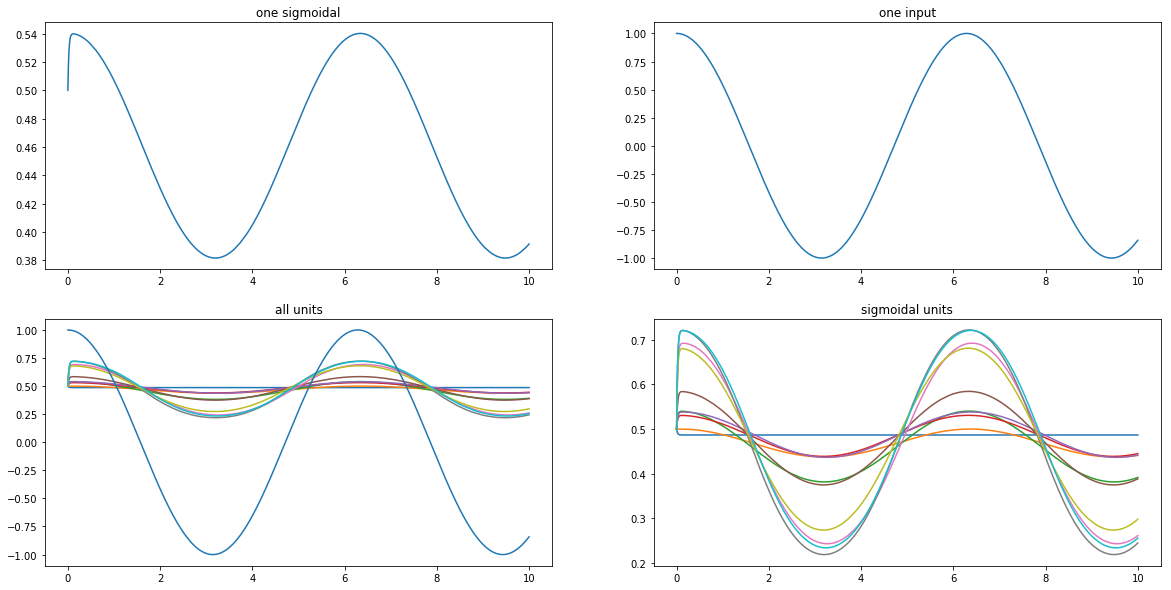

In [12]:
# We can plot the activities of the units using Matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
# Plot the activity of a single sigmoidal unit
plt.subplot(221)
plt.plot(times, unit_acts[sig_ids[2]])
plt.title('one sigmoidal')
# Plot the activity of the input unit
plt.subplot(222)
plt.plot(times, unit_acts[inp_ids[0]])
plt.title('one input')
# Plot the activity of all units
plt.subplot(223)
plt.plot(times, np.transpose(unit_acts))
plt.title('all units')
# Plot the activity of all sigmoidal units
plt.subplot(224)
sig_acts = [ unit_acts[u] for u in sig_ids ]
plt.plot(times, np.transpose(sig_acts))
plt.title('sigmoidal units')
plt.show()

### Technical note:
Importing a "cythonized" draculab is easy to do from the Jupyter notebook. The `from draculab import * ` command must be replaced by two separate cells. The first one contains the following:

    %load_ext Cython

The second cell contains this:

    %%cython
    from draculab import *

## Part 2
The main attributes of the `network` object.

The network created in Part 1 has 10 sigmoidal units, each one receiving one connection. 
Morevoer, each connection has a particular delay, and its own synapse. The delays are scalar values,
but synapses are objects with their own attributes.

All the connection information in draculab is stored in 3 lists, which are attributes of the network object.
* **delays**. `delays[i]` is a list that contains the delays for all the connections received by the unit whose ID is `i`. `delays[i][j]` is the delay of the j-th connection to unit i. 
* **syns**. `syns[i]` is a list that contains the synapses of all the connections received by the unit whose ID is `i`. `syns[i][j]` is the synapse object for the j-th connection to unit i.
* **act**. `act[i]` is a list whose elements are Python functions. `act[i][j]` is the function from which unit i obtains its j-th input.

All the units created are stored in the `network.units` list. `network.units[i]` is the unit object whose ID is `i`.
When plants are created, they are stored in the `network.plants` list.

In [13]:
# We can look at the units of the network created in part 1
net.units

In [14]:
# Similarly, we can look at the delays, synapses, and activity functions.
net.delays

[[0.035],
 [0.055],
 [0.035],
 [0.02],
 [0.09],
 [0.025],
 [0.1],
 [0.035],
 [0.02],
 [0.075],
 []]

In [15]:
# The attribute containing the synaptic weight in the synapse objects is called w
net.syns[2][0].w  # for unit 'n', w = 0.1*n

0.2

In [16]:
# Another useful attribute in the synapses are the IDs of the presynaptic and postsynaptic units,
# contained in the preID and postID attributes respectively
net.syns[2][0].preID

10

In [17]:
# All sigmoidals obtain their inputs from the same cosine function
net.act[0][0](3.141592)

-0.9999999999997864

## Part 3
Create 10 input units, connect them to the 10 sigmoidals.

This unit is intended to show the proper way to initialize the function of source units.

***Plase reset the kernel before continuing***

In [1]:
# Importing...
%cd .. 
from draculab import *
import matplotlib.pyplot as plt

/home/z/projects/draculab


In [2]:
# We once more create the network as before, this time with 10 source units
net_params = {
    'min_delay' : 0.005, # minimum delay in all the network's connections (in seconds)
    'min_buff_size' : 10 } # minimum buffer size. How many values are stored per simulation step. 
net = network(net_params)

n_sigs = 10 # how many sigmoidal units to create
sig_params = {
    'type' : unit_types.sigmoidal,  # unit_types is an Enum in draculab.py
    'init_val' : 0.5, # initial value
    'thresh' : .1, # all sigmoidal units will have threshold 1
    'slope' : np.random.uniform(0.5, 2., n_sigs), # the slopes come from a random distribution
    'tau' : 0.02 } # time constant for the dynamics of all sigmoidal units
sig_ids = net.create(n_sigs, sig_params)

n_sources = 10 # how many input units to create
input_params = {
    'type' : unit_types.source,
    'init_val' : 0.5,
    'function' : lambda t: None } 
inp_ids = net.create(n_sources, input_params)

# Notice that the created source units have a function that returns 'None'. 
# We need to initialize their functions. To do this we create an auxiliary function.

def create_cosine(ang_freq, phase):
    return lambda t: np.cos(ang_freq*(t - phase))

# With our auxiliary function we now initialize the function of all source units
for idx, uid in enumerate(inp_ids):
    net.units[uid].set_function(create_cosine(2.*np.pi, 0.1*idx))

### The whole point of part 3 is to show that the auxiliary function is necessary.
In other words, initializing the source units using
```
for idx, uid in enumerate(inp_ids):
    net.units[uid].set_function(lambda t : np.cos(2.*np.pi*t - 0.1*idx))
```
will lead to a subtle error. If interested see: https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/

In [3]:
# We connect the units, and run the simulation
# This time, each sigmoidal unit gets its own input, with a unique phase
conn_spec = {
    'rule' : 'one_to_one',  # all sources connect to all targets
    'delay' : {'distribution': 'uniform', 'low': 0.01, 'high':0.1} }# connection delays will be uniformly distributed
syn_spec = {
    'type': synapse_types.static, # synapse_types is an Enum in draculab.py
    'init_w' : [0.1*n for n in range(n_sigs)] } # the initial weights range from 0. to 0.9
net.connect(inp_ids, sig_ids, conn_spec, syn_spec)

sim_time = 10. # simulation time
times, unit_acts, _ = net.run(sim_time)

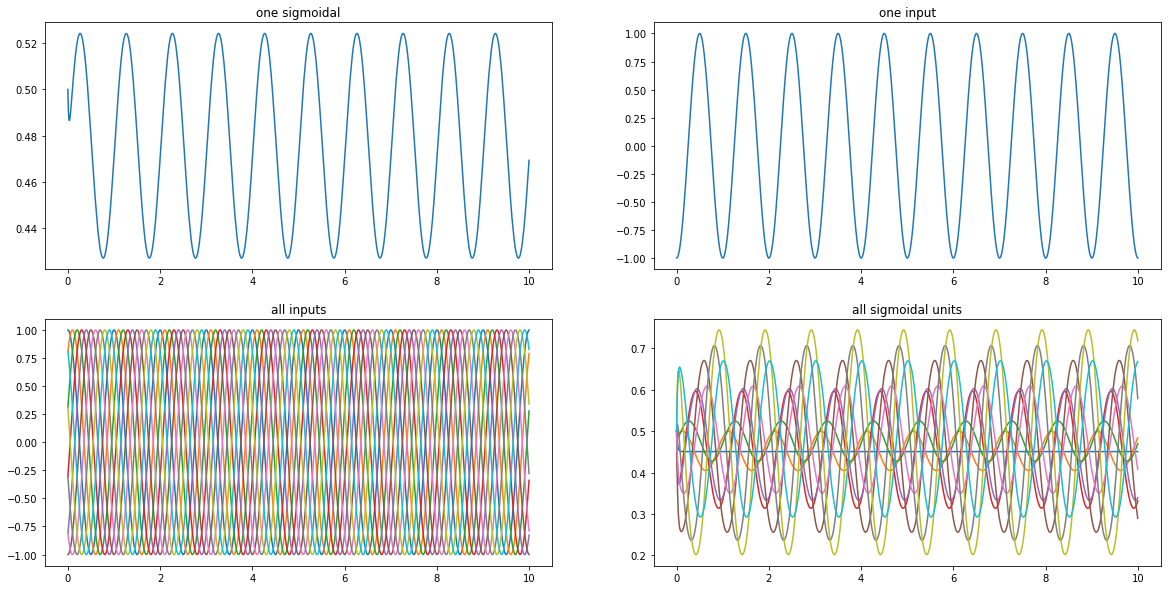

In [4]:
# Plot the activities of the units using Matplotlib

fig = plt.figure(figsize=(20,10))
# Plot the activity of a single sigmoidal unit
plt.subplot(221)
plt.plot(times, unit_acts[sig_ids[2]])
plt.title('one sigmoidal')
# Plot the activity of one input unit
plt.subplot(222)
plt.plot(times, unit_acts[inp_ids[5]])
plt.title('one input')
# Plot the activity of all inputs
inp_acts = [ unit_acts[u] for u in inp_ids ]
plt.subplot(223)
plt.plot(times, np.transpose(inp_acts))
plt.title('all inputs')
# Plot the activity of all sigmoidal units
plt.subplot(224)
sig_acts = [ unit_acts[u] for u in sig_ids ]
plt.plot(times, np.transpose(sig_acts))
plt.title('all sigmoidal units')
plt.show()

### Exercise 1
Create a numpy 2D array `weights` that contains all the synaptic weights.
`weights[i,j]` should be the weight of the connection from unit `j` to unit `i`. If the units are not connected it should equal zero.

***BONUS:***
Plot the connection matrix as an image

Solution is below.

### Exercise 2
What happens if you don't use the auxiliary function to initialize the input in part 3?

### Exercise 3
Repeat part 3, but this time connect the sigmoidal units so that unit 0 projects to unit 1, unit 1 to unit 2, ..., unit 9 to unit 0.  
Use delays of 0.01, and static synapses with weight 0.5.

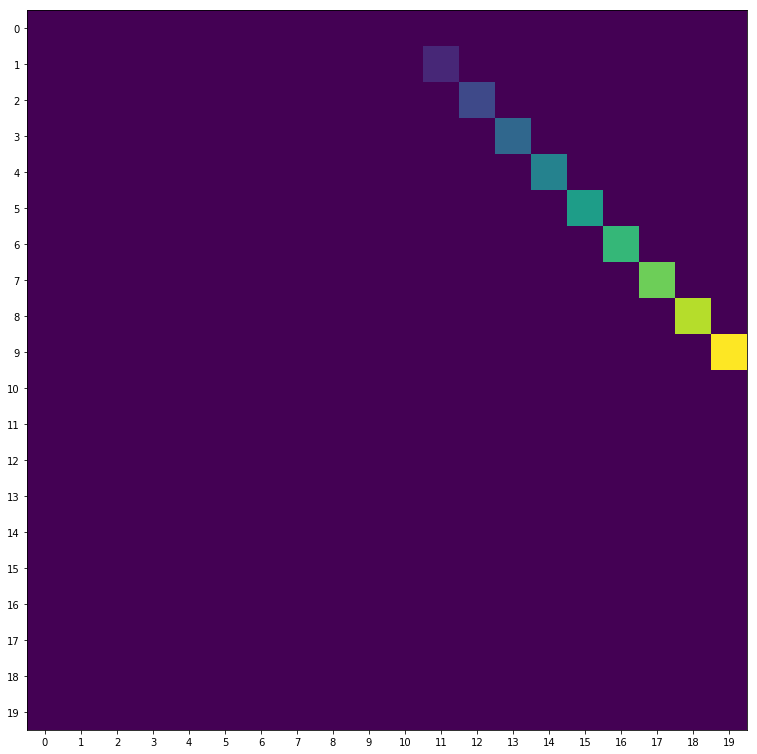

In [5]:
# SOLUTION TO EXERCISE 1
N = len(net.units) # number of units
weights = np.zeros((N,N)) 
for syn_list in net.syns:
    for syn in syn_list:
        weights[syn.postID, syn.preID] = syn.w

# BONUS
fig_ex1 = plt.figure(figsize=(10,10))
ax = fig_ex1.add_axes([0., 0., 1., 1.], aspect=1)
ax.set_xticks(list(range(N)))
ax.set_yticks(list(range(N)))
ax.imshow(weights)
plt.show()

In [ ]:
# SOLUTION TO EXERCISE 2

# All the input units are initialized with the same function.

In [ ]:
# SOLUTION TO EXERCISE 3
#--------------- copy-paste ---------------
%cd .. 
from draculab import *
import matplotlib.pyplot as plt

net_params = {
    'min_delay' : 0.005, # minimum delay in all the network's connections (in seconds)
    'min_buff_size' : 10 } # minimum buffer size. How many values are stored per simulation step. 
net = network(net_params)

n_sigs = 10 # how many sigmoidal units to create
sig_params = {
    'type' : unit_types.sigmoidal,  # unit_types is an Enum in draculab.py
    'init_val' : 0.5, # initial value
    'thresh' : .1, # all sigmoidal units will have threshold 1
    'slope' : np.random.uniform(0.5, 2., n_sigs), # the slopes come from a random distribution
    'tau' : 0.02 } # time constant for the dynamics of all sigmoidal units
sig_ids = net.create(n_sigs, sig_params)

n_sources = 10 # how many input units to create
input_params = {
    'type' : unit_types.source,
    'init_val' : 0.5,
    'function' : lambda t: None } 
inp_ids = net.create(n_sources, input_params)

def create_cosine(ang_freq, phase):
    return lambda t: np.cos(ang_freq*(t - phase))

for idx, uid in enumerate(inp_ids):
    net.units[uid].set_function(create_cosine(2.*np.pi, 0.1*idx))
    
conn_spec = {
    'rule' : 'one_to_one',  # all sources connect to all targets
    'delay' : {'distribution': 'uniform', 'low': 0.01, 'high':0.1} }# connection delays will be uniformly distributed
syn_spec = {
    'type': synapse_types.static, # synapse_types is an Enum in draculab.py
    'init_w' : [0.1*n for n in range(n_sigs)] } # the initial weights range from 0. to 0.9
net.connect(inp_ids, sig_ids, conn_spec, syn_spec)
#--------------------------------------

# THE ACTUAL SOLUTION
s2s_conn_spec = {
    'rule' : 'one_to_one',  
    'delay' : 0.01 }
s2s_syn_spec = {
    'type': synapse_types.static, 
    'init_w' : 0.5 }
target_ids = [(i+1)%n_sigs for i in sig_ids] # assuming sig_ids range from 0 to n_sigs...
net.connect(sig_ids, target_ids, s2s_conn_spec, s2s_syn_spec)

#-------- more copy-paste ----------
sim_time = 10. # simulation time
times, unit_acts, _ = net.run(sim_time)

fig = plt.figure(figsize=(20,10))
# Plot the activity of a single sigmoidal unit
plt.subplot(221)
plt.plot(times, unit_acts[sig_ids[2]])
plt.title('one sigmoidal')
# Plot the activity of one input unit
plt.subplot(222)
plt.plot(times, unit_acts[inp_ids[5]])
plt.title('one input')
# Plot the activity of all inputs
inp_acts = [ unit_acts[u] for u in inp_ids ]
plt.subplot(223)
plt.plot(times, np.transpose(inp_acts))
plt.title('all inputs')
# Plot the activity of all sigmoidal units
plt.subplot(224)
sig_acts = [ unit_acts[u] for u in sig_ids ]
plt.plot(times, np.transpose(sig_acts))
plt.title('all sigmoidal units')
plt.show()

In [ ]:
# Using the solution to exercise 1 to visualize the connections made in exercise 3
N = len(net.units) # number of units
weights = np.zeros((N,N)) 
for syn_list in net.syns:
    for syn in syn_list:
        weights[syn.postID, syn.preID] = syn.w

fig_ex1 = plt.figure(figsize=(10,10))
ax = fig_ex1.add_axes([0., 0., 1., 1.], aspect=1)
ax.set_xticks(list(range(N)))
ax.set_yticks(list(range(N)))
ax.imshow(weights)
plt.show()